In [4]:
""" iTEBD code to find the ground state of 
the 1D Ising model on an infinite chain.
The results are compared to the exact results.
Frank Pollmann, frankp@pks.mpg.de"""

import numpy as np
import scipy
from scipy import integrate
from scipy.linalg import expm 
%matplotlib notebook
import matplotlib.pyplot as plt

# First define the parameters of the model / simulation
# H=JZZ-(g/2)X

J=-1.0; g=0.5; chi=15; d=2; delta=0.005; N=10000;

SE=[]
SN=[]
entropy=[]
glist=np.arange(0.2,3,0.2)
for g in glist:
    print(g)
    B=[];s=[]
    for i in range(2):
        B.append(np.zeros([2,1,1])); B[-1][0,0,0]=1
        s.append(np.ones([1]))

    # Generate the two-site time evolution operator
    H_bond = np.array( [[J,-g/2,-g/2,0], [-g/2,-J,0,-g/2], [-g/2,0,-J,-g/2], [0,-g/2,-g/2,J]] )
    U = np.reshape(expm(-delta*H_bond),(2,2,2,2))

    Mz=np.array( [[J,-g/2,-g/2,0], [-g/2,-J,0,-g/2], [-g/2,0,-J,-g/2], [0,-g/2,-g/2,J]] )

    # Perform the imaginary time evolution alternating on A and B bonds
    for step in range(0, N):
        for i_bond in [0,1]:
            ia = np.mod(i_bond-1,2); ib = np.mod(i_bond,2); ic = np.mod(i_bond+1,2)
            chia = B[ib].shape[1]; chic = B[ic].shape[2]

            # Construct theta matrix and time evolution #
            theta = np.tensordot(B[ib],B[ic],axes=(2,1)) # i a j b
            theta = np.tensordot(U,theta,axes=([2,3],[0,2])) # ip jp a b 
            theta = np.tensordot(np.diag(s[ia]),theta,axes=([1,2])) # a ip jp b 
            theta = np.reshape(np.transpose(theta,(1,0,2,3)),(d*chia,d*chic)) # ip a jp b

            # Schmidt deomposition #
            #X, Y, Z = np.linalg.svd(theta,full_matrices=0)			
            [X,Y,Z]=scipy.linalg.svd(theta, lapack_driver='gesvd')
            chi2 = np.min([np.sum(Y>10.**(-10)), chi])	

            piv = np.zeros(len(Y), np.bool)
            piv[(np.argsort(Y)[::-1])[:chi2]] = True

            Y = Y[piv]; invsq = np.sqrt(sum(Y**2))
            X = X[:,piv] 
            Z = Z[piv,:]

            # Obtain the new values for B and s #
            s[ib] = Y/invsq 

            X=np.reshape(X,(d,chia,chi2))
            X = np.transpose(np.tensordot(np.diag(s[ia]**(-1)),X,axes=(1,1)),(1,0,2))
            B[ib] = np.tensordot(X, np.diag(s[ib]),axes=(2,0))

            B[ic] = np.transpose(np.reshape(Z,(chi2,d,chic)),(1,0,2))
        E=[]
        EE=[]
        for i_bond in range(2):
            BB = np.tensordot(B[i_bond],B[np.mod(i_bond+1,2)],axes=(2,1))
            sBB = np.tensordot(np.diag(s[np.mod(i_bond-1,2)]),BB,axes=(1,1))
            C = np.tensordot(sBB,np.reshape(H_bond,[d,d,d,d]),axes=([1,2],[2,3]))
            sBB=np.conj(sBB)
            E.append(np.squeeze(np.tensordot(sBB,C,axes=([0,3,1,2],[0,1,2,3]))).item()) 
            ee=0
            S=s[i_bond]
            for p in range(0,len(s[i_bond])):
                if S[p]>1e-8:
                    ee=ee-(S[p])*np.log(S[p])
            EE.append(ee)
    SN.append(np.mean(E))
    entropy.append(np.mean(EE))
    f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
    E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]
    SE.append(E0_exact)

0.2
0.4
0.6
0.8
1.0
1.2
1.4
1.6
1.8
2.0
2.2
2.4
2.6
2.8


<IPython.core.display.Javascript object>


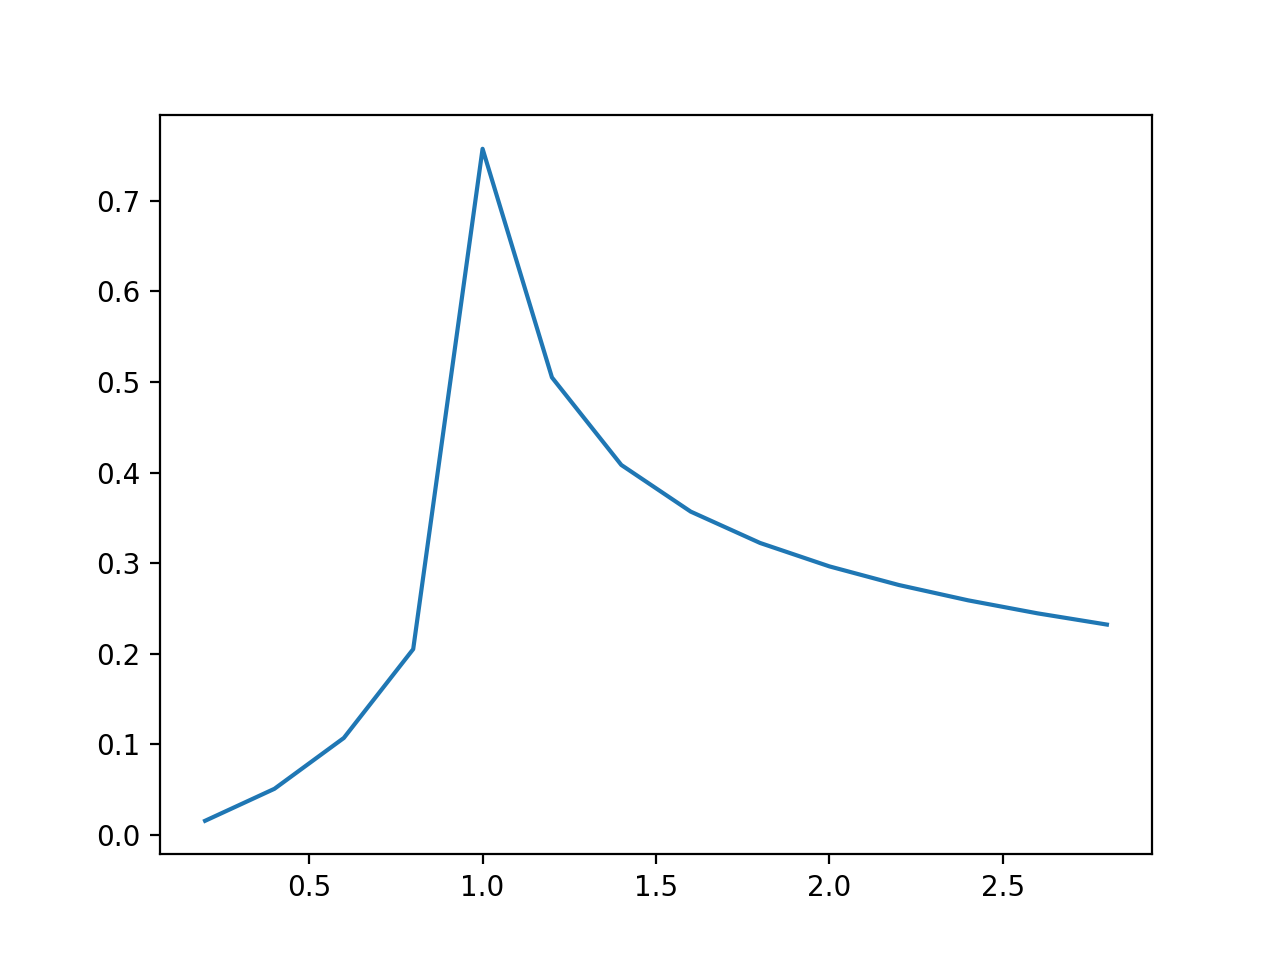

In [5]:
# plt.close()
#plt.figure(1)
plt.plot(glist,entropy)
plt.show()

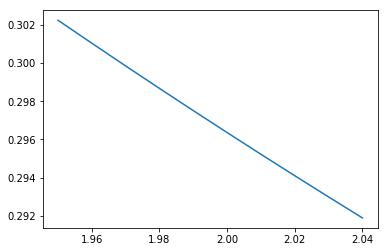

In [31]:
# plt.close()
#plt.figure(1)
plt.plot(glist,entropy)
plt.show()

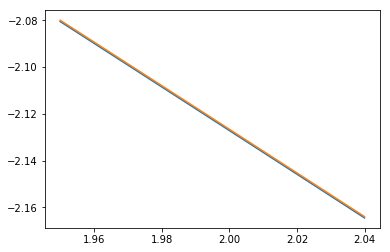

In [12]:
# plt.close()
#plt.figure(1)
plt.plot(glist,SE)
plt.plot(glist,SN)
plt.show()

In [20]:
SED=list()
for p in range(0,len(SE)-1):
    SED.append(entropy[p+1]-entropy[p])

In [21]:
SED

[-0.0012030680030450935,
 -0.001188843917179716,
 -0.0011749319267339575,
 -0.0011613219004800723,
 -0.001148004137364933,
 -0.0011349693441944364,
 -0.0011222086145309951,
 -0.0011097134091732075,
 -0.00109747553742362]